Code for **"Blind restoration of a JPEG-compressed image"** and **"Blind image denoising"** figures. Select `fname` below to switch between the two.

- To see overfitting set `num_iter` to a large value.

In [4]:
"""
*Uncomment if running on colab* 
Set Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab 
"""
!git clone https://github.com/galenreed/deep-image-prior
!mv deep-image-prior/* ./

'\n*Uncomment if running on colab* \nSet Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab \n'

# Import libs

In [43]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import numpy as np
from models import *

import torch
import torch.optim
from PIL import Image

from skimage.measure import compare_psnr
from utils.denoising_utils import *
from scipy.io import loadmat, savemat

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

imsize = 64
PLOT = True
sigma = 6
sigma_ = sigma/255.

(128, 128, 8, 3)


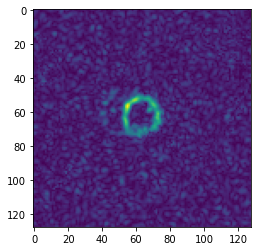

In [44]:



fname = 'data/c13images/P1.mat'
x = loadmat(fname)
imgArray = x['img']
print(imgArray.shape)
sampleImg = imgArray[:,:,2,0]
imReal = np.float32(np.real(sampleImg))
imImag = np.float32(np.imag(sampleImg))
nx = imgArray.shape[0]
ny = imgArray.shape[1]

imComplex = np.zeros([3, nx, ny])
imComplex[0,:,:] = imReal
imComplex[1,:,:] = imImag

# scale from -1 to 1
imComplex = scaleToMaxOne(imComplex)

plt.imshow(colorToMagnitude(imComplex))

# Setup

In [42]:
INPUT = 'noise' # 'meshgrid'
pad = 'reflection'
OPT_OVER = 'net' # 'net,input'

reg_noise_std = .06 # set to 1./20. for sigma=50
LR = 0.001

OPTIMIZER='adam' # 'LBFGS'
show_every = 100
exp_weight=0.99

num_iter = 2000
input_depth = 32 
figsize = 4 
    
    
    
    
net = get_net(input_depth, 'skip', pad,
              skip_n33d=128, 
              skip_n33u=128, 
              skip_n11=4, 
              num_scales=5,
              n_channels=3,
              upsample_mode='bilinear').type(dtype)


    
net_input = get_noise(input_depth, INPUT, (ny, nx)).type(dtype).detach()

# Compute number of parameters
s  = sum([np.prod(list(p.size())) for p in net.parameters()]); 
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_noisy_np = imComplex
img_noisy_torch = np_to_torch(img_noisy_np).type(dtype)

RuntimeError: Cannot initialize CUDA without ATen_cuda library. PyTorch splits its backend into two shared libraries: a CPU library and a CUDA library; this error has occurred because you are trying to use some CUDA functionality, but the CUDA library has not been loaded by the dynamic linker for some reason.  The CUDA library MUST be loaded, EVEN IF you don't directly use any symbols from the CUDA library! One common culprit is a lack of -Wl,--no-as-needed in your link arguments; many dynamic linkers will delete dynamic library dependencies if you don't depend on any of their symbols.  You can check if this has occurred by using ldd on your binary to see if there is a dependency on *_cuda.so library.

# Optimize

In [ ]:
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
out_avg = None
last_net = None
psrn_noisy_last = 0

i = 0
def closure():
    
    global i, out_avg, psrn_noisy_last, last_net, net_input
    
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
    
    out = net(net_input)
    
    # Smoothing
    if out_avg is None:
        out_avg = out.detach()
    else:
        out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight)
            
    total_loss = mse(out, img_noisy_torch)
    total_loss.backward()
        
    
    psrn_noisy = compare_psnr(img_noisy_np, out.detach().cpu().numpy()[0]) 
    #psrn_gt    = compare_psnr(img_np, out.detach().cpu().numpy()[0]) 
    #psrn_gt_sm = compare_psnr(img_np, out_avg.detach().cpu().numpy()[0]) 
    
    # Note that we do not have GT for the "snail" example
    # So 'PSRN_gt', 'PSNR_gt_sm' make no sense
    #print ('Iteration %05d    Loss %f   PSNR_noisy: %f   PSRN_gt: %f PSNR_gt_sm: %f' % (i, total_loss.item(), psrn_noisy, psrn_gt, psrn_gt_sm), '\r', end='')
    if  PLOT and i % show_every == 0:
        
        im_out = torch_to_np(out)
        im_avg = torch_to_np(out_avg)
        
        plot_image_grid([np.clip(im_out, 0, 1), 
                         np.clip(im_avg, 0, 1)], factor=figsize, nrow=1)
        
        
    
    # Backtracking
    if i % show_every:
        if psrn_noisy - psrn_noisy_last < -5: 
            print('Falling back to previous checkpoint.')

            for new_param, net_param in zip(last_net, net.parameters()):
                net_param.data.copy_(new_param.cuda())

            return total_loss*0
        else:
            last_net = [x.detach().cpu() for x in net.parameters()]
            psrn_noisy_last = psrn_noisy
            
    i += 1

    return total_loss

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

In [ ]:
#out_np = torch_to_np(net(net_input))
#q = plot_image_grid([np.clip(out_np, 0, 1), img_np], factor=13);

out_img = colorToMagnitude(torch_to_np(net(net_input)))
in_img = colorToMagnitude(imComplex)
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,10))
ax1.imshow(in_img, cmap='gray')
ax2.imshow(out_img, cmap='gray')
ax1.axis('off')
ax2.axis('off')